/tmp/ipykernel_31339/3033297811.py:9: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, voice = wav.read(f'../Beamforming simulation experiment/Input_voices/voice_{i+1}.wav')


Voice 1 shape[0]: 136649
Voice 1 sampling frequency: 44100
Voice 2 shape[0]: 136649
Voice 2 sampling frequency: 44100
Voice 3 shape[0]: 136649
Voice 3 sampling frequency: 44100


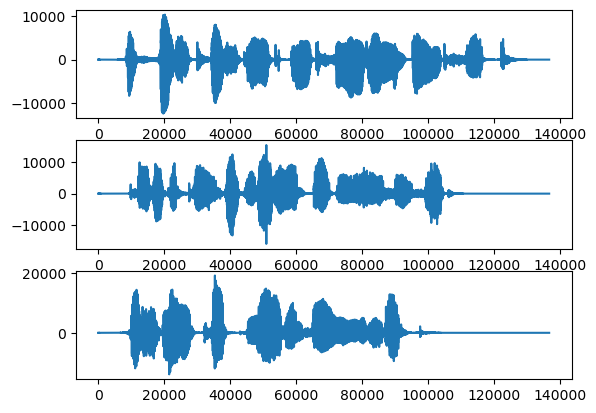

In [1]:
from scipy.io import wavfile as wav
import numpy as np
from matplotlib import pyplot as plt
from class_defs import virtualizer

sampling_frequencies = []
voices = []
for i in range(3):
    fs, voice = wav.read(f'../Beamforming simulation experiment/Input_voices/voice_{i+1}.wav')
    voice = np.array(voice, dtype=np.float32)[:, 0] # form a numpy array from the first channel

    print(f'Voice {i+1} shape[0]: {voice.shape[0]}')
    print(f'Voice {i+1} sampling frequency: {fs}')

    voices.append(voice)
    sampling_frequencies.append(fs)

# plot the voices in subplots
plt.subplot(3, 1, 1)
plt.plot(voices[0])
plt.subplot(3, 1, 2)
plt.plot(voices[1])
plt.subplot(3, 1, 3)
plt.plot(voices[2])
plt.show()

In [2]:
# pad each of the voices to be the same length
max_length = max([voice.shape[0] for voice in voices])
for i in range(3):
    pad_length = max_length-voices[i].shape[0]
    if pad_length:
        voices[i] = np.pad(voices[i], (0, max_length-voices[i].shape[0]))

# pad each of the voices to be multiples of 1024
for i in range(3):
    pad_length = 1024-voices[i].shape[0]%1024
    if pad_length:
        voices[i] = np.pad(voices[i], (0, 1024-voices[i].shape[0]%1024))

# print the new shapes
for i in range(3):
    print(f'Voice {i+1} shape[0]: {voices[i].shape[0]}, {voices[i].shape[0]/1024} blocks of 1024')

# take the number of blocks (should be shared by all voices now)
n_blocks = voices[0].shape[0]//1024

Voice 1 shape[0]: 137216, 134.0 blocks of 1024
Voice 2 shape[0]: 137216, 134.0 blocks of 1024
Voice 3 shape[0]: 137216, 134.0 blocks of 1024


In [3]:
# chop each voice into length-1024 samples blocks
for i in range(3):
    voices[i] = np.split(voices[i], n_blocks) # voices[i] is now a Python list of chunks as numpy arrays

Here is where the virtualizers will be declared, and `voices` will be processed 
through them, producing a list of blocks called `processed_voices`. Each block 
is a tuple of stereo blocks.

It's done is a style that feeds a block into each virtualizer before moving on 
to the next set of blocks. However, this effectively transposes the dimensions from 
`(speaker, chunk)` to `(chunk, speaker)`, then adds the left-right channel dimension, 
making the final set of dimensions `(chunk, speaker, l/r channel)`

In [4]:
virtualizers = [virtualizer('l'), virtualizer('c'), virtualizer('r')]
processed_voices = [
    [
        virtualizers[0].virtualize(block_left), 
        virtualizers[1].virtualize(block_center), 
        virtualizers[2].virtualize(block_right),
    ] 
    for block_left, block_center, block_right in zip(voices[0], voices[1], voices[2])
]

In [5]:
processed_voices[0][0][0].shape # [chunk, speaker, l/r channel]

(1024,)

In [6]:
def process(left_spkr_chunk, center_spkr_chunk, right_spkr_chunk):
    # these chunks are stereo, and we need to mix each channel separately
    left_chann_chunk = left_spkr_chunk[0]+center_spkr_chunk[0]+right_spkr_chunk[0]
    right_chann_chunk = left_spkr_chunk[1]+center_spkr_chunk[1]+right_spkr_chunk[1]
    return left_chann_chunk, right_chann_chunk

final_stereo_chunks = [
    process(left_spkr_chunk, center_spkr_chunk, right_spkr_chunk) 
    for left_spkr_chunk, center_spkr_chunk, right_spkr_chunk in processed_voices
]

(137216, 2)


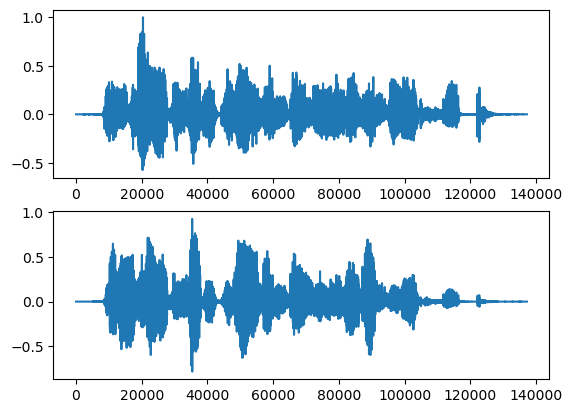

In [7]:
final_stereo = np.hstack(final_stereo_chunks).T
print(final_stereo.shape)

# final processing: normalization, stripping imag component
final_stereo = np.real(final_stereo)
maximum = np.max(final_stereo, axis=None) # don't care about axis
final_stereo /= maximum

plt.subplot(2, 1, 1)
plt.plot(final_stereo[:, 0])
plt.subplot(2, 1, 2)
plt.plot(final_stereo[:, 1])
plt.show()

In [8]:
final_stereo_int = (32767*final_stereo).astype(np.int16)
wav.write('final_stereo.wav', 44100, final_stereo_int)